In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [3]:
import os
import matplotlib.pyplot as plt

imdb_dir = '/Users/remi/Desktop/projects/keras/chapter6/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')


def tokenize(directory):
    labels = []
    texts = []

    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(directory, label_type)
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                with open(os.path.join(dir_name, fname)) as f:
                    texts.append(f.read())
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)

    return texts, labels


def plot_loss(loss_values, val_loss_values):
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def plot_accuracy(acc, val_acc):
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

texts, labels = tokenize(train_dir)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=max_len)
labels = np.asarray(labels)
print(f'Shape of data tensor : {data.shape}')
print(f'Shape of label tensor : {labels.shape}')

# Shuffle data because they are ordered pneg then pos
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]


Found 88582 unique tokens.
Shape of data tensor : (25000, 100)
Shape of label tensor : (25000,)


In [5]:
glove_dir = '/Users/remi/Desktop/projects/keras/chapter6/glove.6B'

embedding_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors.')


Found 400000 word vectors.


In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 1.8956 - acc: 0.5050 - val_loss: 0.6896 - val_acc: 0.5379
Epoch 2/10
200/200 [==============================] - 0s 831us/step - loss: 0.5925 -

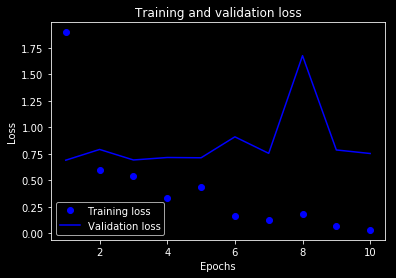

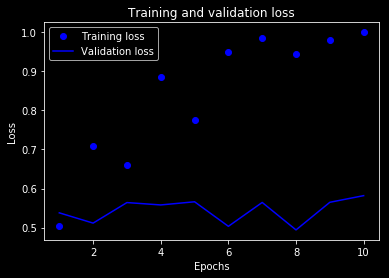

In [7]:
# Train pre-trained word embedding (Glove)
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

plot_loss(history.history['loss'], history.history['val_loss'])
plot_loss(history.history['acc'], history.history['val_acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6941 - acc: 0.4950 - val_loss: 0.6955 - val_acc: 0.5178
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5001 - a

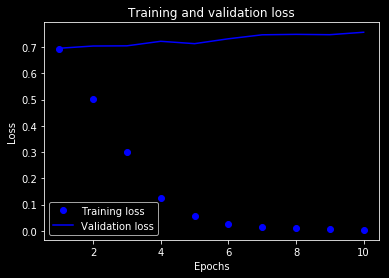

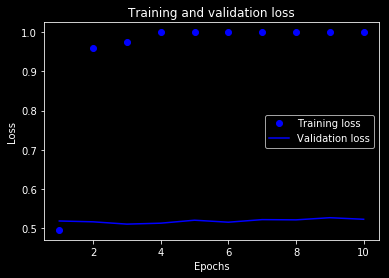

In [8]:
# Try again, without pre-trained word embedding this time
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

plot_loss(history.history['loss'], history.history['val_loss'])
plot_loss(history.history['acc'], history.history['val_acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 4s 372us/step - loss: 0.5089 - acc: 0.7373 - val_loss: 0.3747 - val_acc: 0.8352
Epoch 2/10
10000/10000 [==============================] - 3s 335us/step - lo

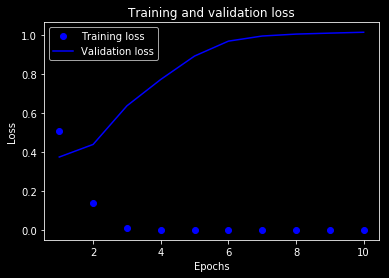

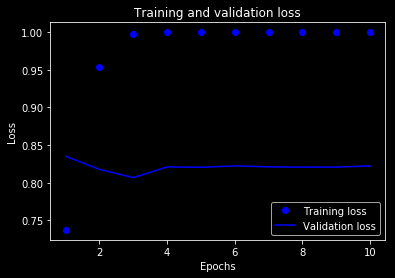

In [9]:
# Try again with many more training samples
training_samples = 10000

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

plot_loss(history.history['loss'], history.history['val_loss'])
plot_loss(history.history['acc'], history.history['val_acc'])


In [10]:
# Evaluate on test data
texts, labels = tokenize(test_dir)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 21us/step


[0.7599237943649292, 0.57212]